In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import mat73
import arviz as az
import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.rectified_logistic import RectifiedLogistic
from hb_mep.models.rats.saturated_relu import SaturatedReLU
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

nMax = 4
df = None

for i in range(1, nMax):
    participant = f"amap{i:02}"
    PREFIX = f"rats_data/{participant}/*"

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*auc_table.csv"))[0]
    temp_df = pd.read_csv(fpath)

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*ep_matrix.mat"))[0]
    data_dict = mat73.loadmat(fpath)
    temp_mat = data_dict["ep_sliced"]

    if df is None:
        time = data_dict["t_sliced"]
    else:
        assert((data_dict["t_sliced"] == time).all())

    temp_df["participant"] = participant
    temp_df["segment"] = temp_df.channel2_segment
    temp_df["method"] = temp_df.channel2_laterality

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_df.reset_index(drop=True, inplace=True)

    temp_mat = temp_mat[idx, :, :]

    if df is None:
        df = temp_df.copy()
        mat = temp_mat
    else:
        df = pd.concat([df, temp_df], ignore_index=True).copy()
        mat = np.vstack((mat, temp_mat))

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)


2023-05-25 09:34:10,521 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-25 09:34:10,529 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-25 09:34:10,529 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


### Rectified Linear

#### Initialize model

In [5]:
model_relu = ReLU(config)

#### Run MCMC inference

In [6]:
mcmc_relu, posterior_samples_relu = model_relu.run_inference(df=df)

2023-05-22 10:03:10,314 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-22 10:03:10,315 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-22 10:03:10,315 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-22 10:03:10,316 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-22 10:03:10,317 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-22 10:03:10,363 - hb_mep.models.relu - INFO - Running inference with ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-22 10:08:49,404 - hb_mep.utils.utils - INFO - func:run_inference took: 5 min and 39.09 sec


#### Diagnostics

In [7]:
mcmc_relu.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]      0.98      0.87      0.82      0.00      2.19   1662.46      1.00
                 a[0,1]      1.10      0.15      1.11      0.80      1.39   6091.38      1.00
                 a[0,2]      2.78      1.42      3.04      0.00      4.75   2382.16      1.00
                 a[0,3]      3.77      0.31      3.77      3.18      4.39   5101.10      1.00
                 a[0,4]      2.65      0.58      2.57      1.97      3.26    795.81      1.00
                 a[0,5]      4.87      3.47      4.50      0.00     10.28   3054.16      1.00
                 a[0,6]      2.90      0.11      2.91      2.74      3.08   1320.15      1.00
                 a[0,7]      1.44      0.17      1.47      1.03      1.71   4652.63      1.00
                 a[0,8]      1.07      0.33      1.07      0.02      1.62     38.29      1.12
                 a[0,9]      1.99      0.24      1.89      

#### Plot fitted curves

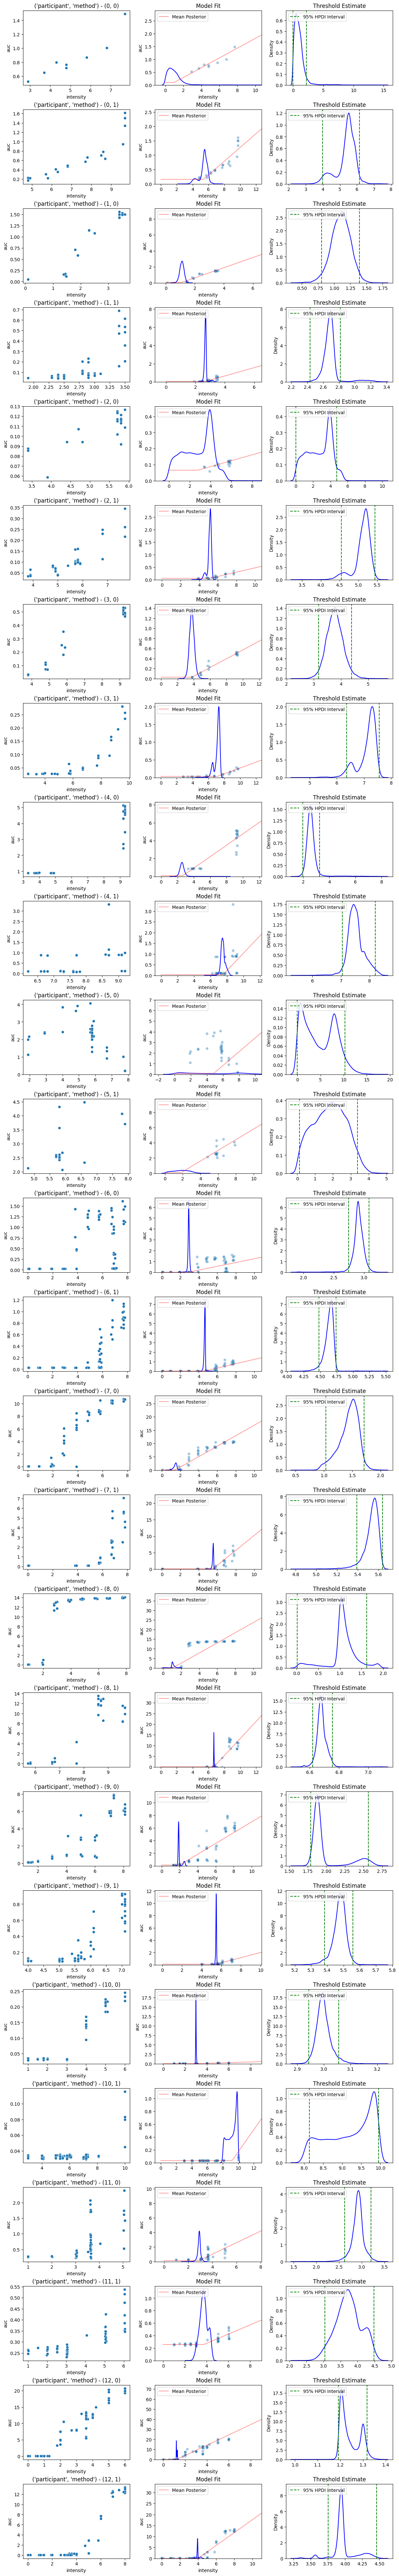

In [8]:
model_relu.plot(df=df, posterior_samples=posterior_samples_relu);

#### Information Criterion

In [9]:
numpyro_data_relu = az.from_numpyro(mcmc_relu)

##### Loo

In [10]:
az.loo(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   724.13    89.56
p_loo      174.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1102   94.6%
 (0.5, 0.7]   (ok)         24    2.1%
   (0.7, 1]   (bad)         8    0.7%
   (1, Inf)   (very bad)   31    2.7%

##### WAIC

In [11]:
az.waic(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   740.92    88.59
p_waic      157.37        -

There has been a warning during the calculation. Please check the results.

### Rectified Logistic

#### Initialize model

In [5]:
model_rectified_logistic = RectifiedLogistic(config)

#### Run MCMC inference

In [6]:
mcmc_rectified_logistic, posterior_samples_rectified_logistic = \
    model_rectified_logistic.run_inference(df=df)

2023-05-25 09:34:22,900 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-25 09:34:22,901 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 09:34:22,901 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 09:34:22,901 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-25 09:34:22,902 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-25 09:34:22,937 - hb_mep.models.rats.rectified_logistic - INFO - Running inference with Rec

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-25 09:40:52,141 - hb_mep.utils.utils - INFO - func:run_inference took: 6 min and 29.24 sec


#### Diagnostics

In [7]:
mcmc_rectified_logistic.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]    124.14      2.68    124.41    118.83    129.14   9437.70      1.00
             a[0,0,1]     45.53      1.37     45.72     42.65     47.76  10205.62      1.00
             a[0,0,2]     39.77      3.45     40.50     33.00     44.31   5043.43      1.00
             a[0,1,0]    128.70      2.00    128.87    124.79    132.24   9868.30      1.00
             a[0,1,1]    114.39      4.62    114.96    104.98    122.32  10139.16      1.00
             a[0,1,2]    110.56      3.42    110.72    103.00    116.25   6426.62      1.00
             a[0,2,0]    207.94      2.72    207.93    202.56    213.72  12773.38      1.00
             a[0,2,1]    227.34      1.98    227.85    223.01    229.99   5840.35      1.00
             a[0,2,2]    168.97      4.38    169.70    159.19    176.24   4942.68      1.00
             a[0,3,0]    207.10      3.20    207.25    200.58    213.68  11274.

#### Plot fitted curves

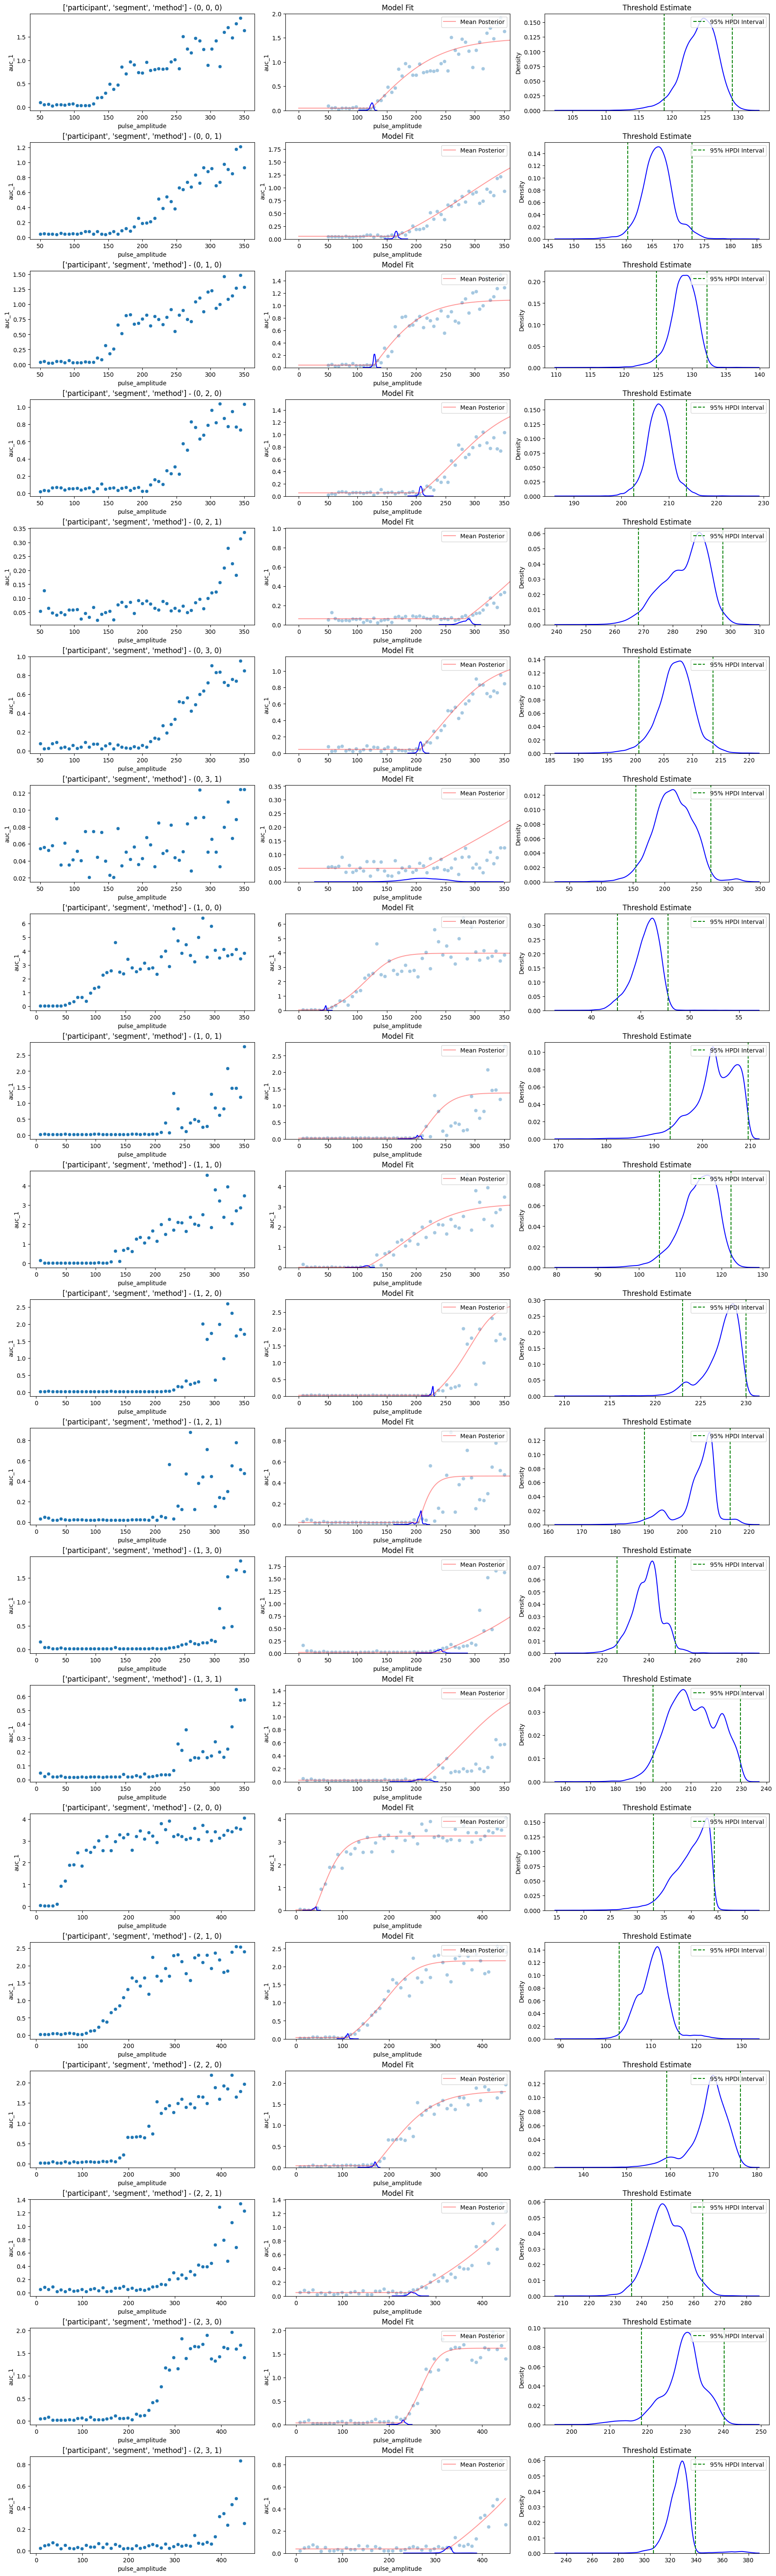

In [8]:
model_rectified_logistic.plot(df=df, posterior_samples=posterior_samples_rectified_logistic);

#### Information Criterion

In [9]:
numpyro_data_rectified_logistic = az.from_numpyro(mcmc_rectified_logistic)

##### Loo

In [10]:
az.loo(numpyro_data_rectified_logistic)


/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1279.57    55.98
p_loo      147.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      960   95.3%
 (0.5, 0.7]   (ok)         18    1.8%
   (0.7, 1]   (bad)        21    2.1%
   (1, Inf)   (very bad)    8    0.8%

##### WAIC

In [11]:
az.waic(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1296.58    54.50
p_waic      130.39        -

There has been a warning during the calculation. Please check the results.

### Saturated Linear

#### Initialize model

In [12]:
model_saturated_relu = SaturatedReLU(config)

#### Run MCMC inference

In [13]:
mcmc_saturated_relu, posterior_samples_saturated_relu = model_saturated_relu.run_inference(df=df)

2023-05-25 09:41:12,756 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturated_ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-25 09:49:06,160 - hb_mep.utils.utils - INFO - func:run_inference took: 7 min and 53.40 sec


#### Diagnostics

In [14]:
mcmc_saturated_relu.print_summary(prob=.95)


                           mean       std    median      2.5%     97.5%     n_eff     r_hat
             a[0,0,0]    121.27      4.33    122.01    112.02    128.52   2639.11      1.00
             a[0,0,1]     46.61      1.18     46.81     44.11     48.34   6353.42      1.00
             a[0,0,2]     38.93      4.64     40.08     29.36     44.51   3600.99      1.00
             a[0,1,0]    128.57      2.15    128.75    124.36    132.40   7287.42      1.00
             a[0,1,1]    114.88      3.43    115.10    108.00    121.12  12927.73      1.00
             a[0,1,2]    112.91      3.25    112.66    106.51    121.22   4687.72      1.00
             a[0,2,0]    208.02      2.58    208.03    202.82    213.48  11237.35      1.00
             a[0,2,1]    228.05      1.73    228.53    224.14    230.37   5074.11      1.00
             a[0,2,2]    167.67      4.61    168.67    157.66    175.25   4834.80      1.00
             a[0,3,0]    206.33      2.95    206.54    200.04    211.69   5706.

#### Plot fitted curves

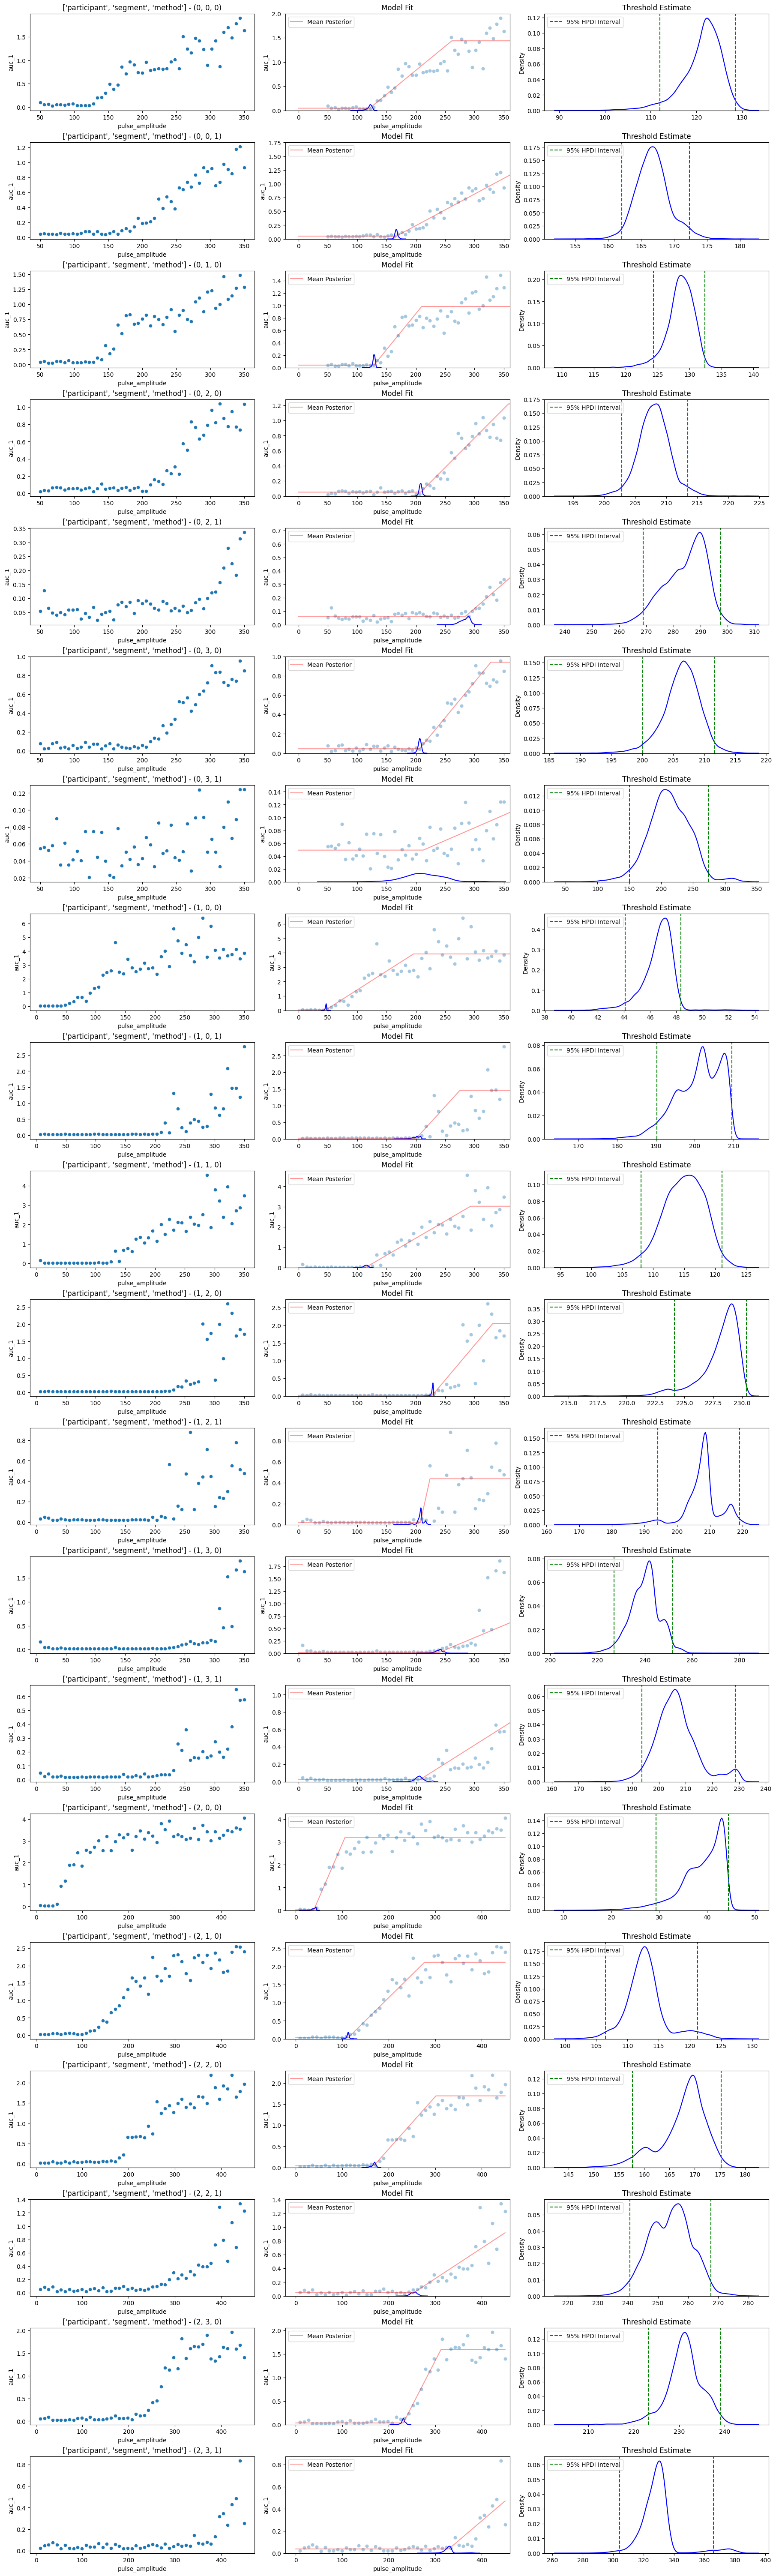

In [15]:
model_saturated_relu.plot(df=df, posterior_samples=posterior_samples_saturated_relu);

#### Information Criterion

In [16]:
numpyro_data_saturated_relu = az.from_numpyro(mcmc_saturated_relu)

##### Loo

In [17]:
az.loo(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1241.84    56.87
p_loo      154.77        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      956   94.9%
 (0.5, 0.7]   (ok)         24    2.4%
   (0.7, 1]   (bad)        17    1.7%
   (1, Inf)   (very bad)   10    1.0%

##### WAIC

In [18]:
az.waic(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1007 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1257.30    55.79
p_waic      139.30        -

There has been a warning during the calculation. Please check the results.

### Model Comparison

In [20]:
az.compare({
    "Rectified_Logistic": numpyro_data_rectified_logistic,
    "Saturated_ReLU": numpyro_data_saturated_relu
})

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pare

rank     elpd_loo       p_loo  elpd_diff        weight  \
Rectified_Logistic     0  1279.570775  147.391814   0.000000  1.000000e+00   
Saturated_ReLU         1  1241.838844  154.766854  37.731932  1.321609e-11   

                           se       dse  warning scale  
Rectified_Logistic  55.980860  0.000000     True   log  
Saturated_ReLU      56.869722  6.215079     True   log